In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import torch
sys.path.append('./')  # uncomment for local import
import tangram as tg
import anndata as ad
%load_ext autoreload
%autoreload 2
%matplotlib inline

tg.__version__
from matplotlib import rcParams

In [2]:
adata_st = sc.read_h5ad("/mnt/disk1/xzhou/data/multi-omics/Hippocampus/visium_hne_adata_crop.h5ad")
# adata_st.obsm['spatial'] = adata_st.obs[['x', 'y']].values
adata_st.X = adata_st.raw.X.astype(int)  ###### MERFISH的counts不是整数，需要强制取整，否则后面报错
adata_st.var_names_make_unique()
adata_st.layers["counts"] = adata_st.X.copy()

In [3]:
sc.pp.highly_variable_genes(adata_st, n_top_genes=2000, flavor="seurat_v3")
sc.pp.normalize_total(adata_st)

In [4]:
rna = adata_st.copy()
rna.obs["domain"] = "Visium"
rna.obs["protocol"] = "Visium"
rna.obs["dataset"] = "Visium"

In [5]:
ad_sp1 = rna.copy()

In [6]:
## An atlas of gene regulatory elements in adult mouse cerebrum.
## 2021 Single-cell chromatin state analysis with Signac.pdf
ad_sc = ad.read_h5ad("/mnt/disk1/xiaojk/data/hippocampus/CEMBA190711_8JE_genescorev2.h5ad") ##直接用之前的数据

In [7]:
ad_sc

AnnData object with n_obs × n_vars = 16270 × 21821
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell_type'
    var: '_index', 'features'

In [8]:
ad_sc.var_names = ad_sc.var['features']

In [9]:
np.unique(ad_sc.X.toarray()[0, :])

array([0., 1., 2., 3., 4., 5., 8.])

In [10]:
sc.pp.normalize_total(ad_sc)

In [11]:
ad_sc.obs_names = ad_sc.obs_names.str.replace(r'^\.', '', regex=True)

In [12]:
ad_sc.obs.cell_type.value_counts()

cell_type
GRC        6546
CA3GL      2480
OGC        2398
ASC        1401
CA1GL      1309
OPC         451
MGL         354
DGNBL       266
VLMC        174
VPIA        161
RGL         149
SSTGA       106
LAMGA        89
VIPGA        80
PVGA         71
IOL          71
CRC          45
PER          40
VEC          23
MSGA         22
LSXGA        21
OBNBL         4
CTGL          2
OLFGL         2
ITL23GL       2
D2MSN         2
ITL4GL        1
Name: count, dtype: int64

In [13]:
cell_type_counts = ad_sc.obs.cell_type.value_counts()

# 找到计数小于100的 cell_type
cell_types_to_remove = cell_type_counts[cell_type_counts < 100].index

# 使用 ~ 运算符来选择那些不在 cell_types_to_remove 中的行
ad_sc_filtered = ad_sc[~ad_sc.obs.cell_type.isin(cell_types_to_remove)]

In [14]:
ad_sc

AnnData object with n_obs × n_vars = 16270 × 21821
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell_type'
    var: '_index', 'features'

In [15]:
ad_sc_filtered

View of AnnData object with n_obs × n_vars = 15795 × 21821
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell_type'
    var: '_index', 'features'

In [16]:
ad_sc = ad_sc_filtered.copy()

In [17]:
sc.tl.rank_genes_groups(ad_sc, groupby="cell_type", use_raw=False)
markers_df = pd.DataFrame(ad_sc.uns["rank_genes_groups"]["names"]).iloc[0:100, :]
markers = list(np.unique(markers_df.melt().value.values))
len(markers)

955

In [19]:
tg.pp_adatas(ad_sc, ad_sp1, genes=markers)

INFO:root:928 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:15041 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [21]:
assert ad_sc.uns['training_genes'] == ad_sp1.uns['training_genes']

In [22]:
ad_map = tg.map_cells_to_space(
    adata_sc=ad_sc,
    adata_sp=ad_sp1,
#     device='cpu',
    device='cuda:1'
)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 928 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.468, KL reg: 0.000
Score: 0.683, KL reg: 0.001
Score: 0.688, KL reg: 0.001
Score: 0.689, KL reg: 0.001
Score: 0.690, KL reg: 0.001
Score: 0.690, KL reg: 0.001
Score: 0.690, KL reg: 0.001
Score: 0.690, KL reg: 0.001
Score: 0.690, KL reg: 0.001
Score: 0.690, KL reg: 0.001


INFO:root:Saving results..


In [70]:
def construct_obs_plot(df_plot, adata, perc=0, suffix=None):
    # clip
    df_plot = df_plot.clip(df_plot.quantile(perc), df_plot.quantile(1 - perc), axis=1)

    # normalize
    df_plot = (df_plot - df_plot.min()) / (df_plot.max() - df_plot.min())

    if suffix:
        df_plot = df_plot.add_suffix(" ({})".format(suffix))
    adata.obs = pd.concat([adata.obs, df_plot], axis=1)
    
    
def plot_cell_annotation_sc(
    adata_sp, 
    annotation_list, 
    x="x", 
    y="y", 
    spot_size=None, 
    scale_factor=None, 
    perc=0,
    alpha_img=1.0,
    bw=False,
    ax=None
):
        
    # remove previous df_plot in obs
    adata_sp.obs.drop(annotation_list, inplace=True, errors="ignore", axis=1)

    # construct df_plot
    df = adata_sp.obsm["tangram_ct_pred"][annotation_list]
    construct_obs_plot(df, adata_sp, perc=perc)
    
    #non visium data 
    if 'spatial' not in adata_sp.obsm.keys():
        #add spatial coordinates to obsm of spatial data 
        coords = [[x,y] for x,y in zip(adata_sp.obs[x].values,adata_sp.obs[y].values)]
        adata_sp.obsm['spatial'] = np.array(coords)
    
    if 'spatial' not in adata_sp.uns.keys() and spot_size == None and scale_factor == None:
        raise ValueError("Spot Size and Scale Factor cannot be None when ad_sp.uns['spatial'] does not exist")
    
    #REVIEW
    if 'spatial' in adata_sp.uns.keys() and spot_size != None and scale_factor != None:
        raise ValueError("Spot Size and Scale Factor should be None when ad_sp.uns['spatial'] exists")
    
    sc.pl.spatial(
        adata_sp, color=annotation_list, cmap="viridis", show=False, frameon=False, spot_size=spot_size,
        scale_factor=scale_factor, alpha_img=alpha_img, bw=bw, colorbar_loc=None,ax=ax, ncols=5,wspace=0
    ) #colorbar_loc=None,

    adata_sp.obs.drop(annotation_list, inplace=True, errors="ignore", axis=1)

In [71]:
list(ad_sc.obs.cell_type.unique())

['ASC',
 'OPC',
 'OGC',
 'RGL',
 'MGL',
 'VPIA',
 'VLMC',
 'CA3GL',
 'CA1GL',
 'GRC',
 'SSTGA',
 'DGNBL']

In [72]:
ad_map

AnnData object with n_obs × n_vars = 15795 × 684
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell_type'
    var: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'cluster', 'domain', 'protocol', 'dataset', 'uniform_density', 'rna_count_based_density'
    uns: 'train_genes_df', 'training_history'

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


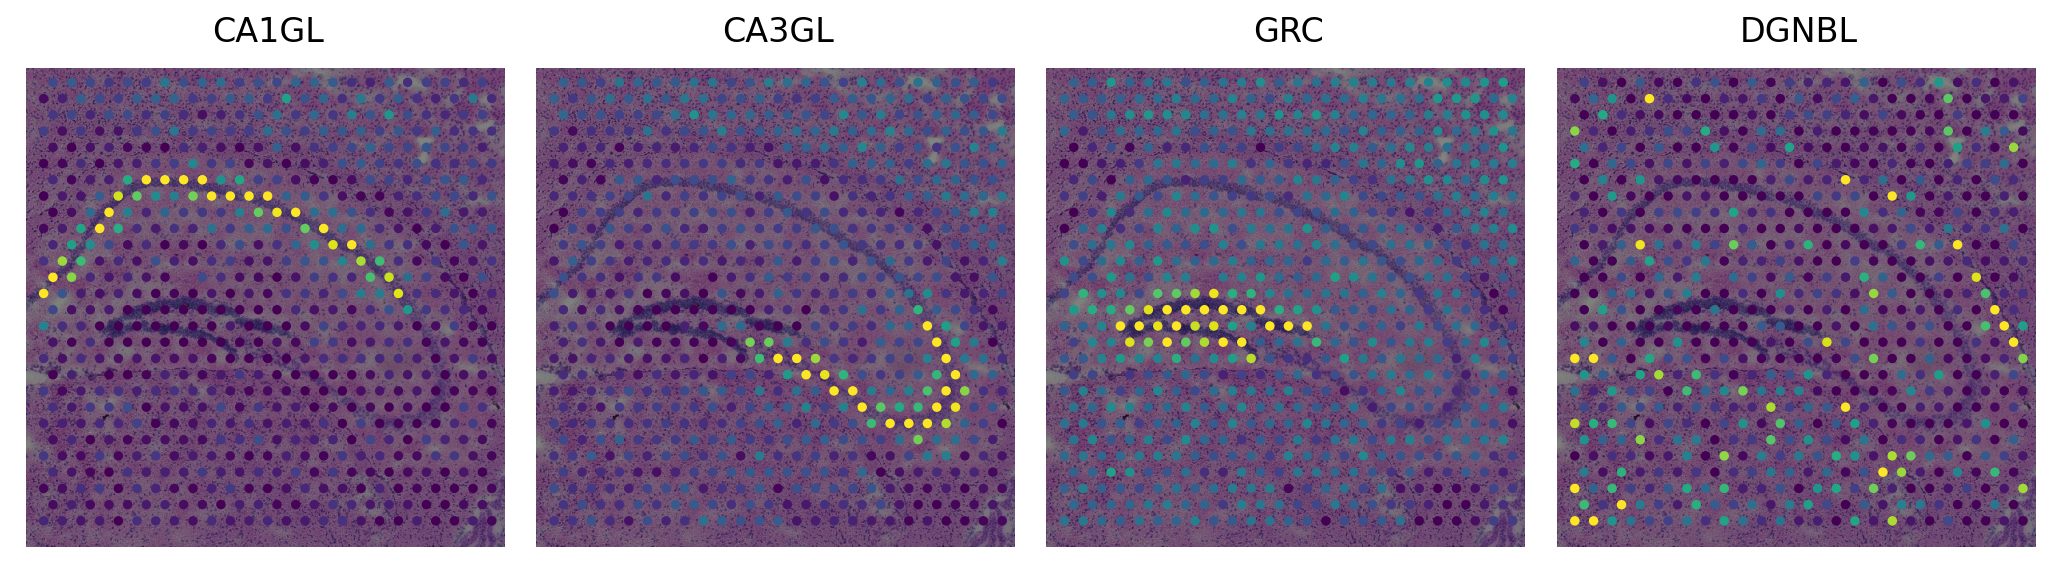

In [73]:
tg.project_cell_annotations(ad_map, ad_sp1 ,annotation="cell_type")
#### 'Pvalb', 'Sst',
##这里由于是FISH数据，每个spot都会对应一个细胞，如果是Visium，则需要对应多个细胞
annotation_list = ['CA1GL', 'CA3GL', 'GRC', 'DGNBL']
# annotation_list = list(atac.obs["cell_type"].unique()) #
sc.settings.set_figure_params(frameon=True, fontsize=15, facecolor='white',figsize=(4, 4)) #dpi=300, 
### plot_cell_annotation_sc(adata_st, annotation_list, x='x', y='y', spot_size= 60, scale_factor=0.1, perc=0.001)
plot_cell_annotation_sc(ad_sp1, annotation_list, perc=0.02, spot_size= 70)

In [ ]:
## An atlas of gene regulatory elements in adult mouse cerebrum.
## 2021 Single-cell chromatin state analysis with Signac.pdf
ad_sc1 = ad.read_h5ad("/mnt/disk1/xiaojk/data/hippocampus/CEMBA190711_8JE_genescore.h5ad") ##直接用之前的数据

In [ ]:
ad_sc.obs[ad_sc.obs_names == 'AACGAGAGCTAGTCCTGGTACT']

In [ ]:
ad_sc1.obs

In [ ]:
ad_sc.X.max()